In [1]:
import sys
sys.path.insert(1, '/Users/Andrew/Documents/PhD/Scripts/Python/pygplates_rev13')
import pygplates
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as mplcm
from create_gpml import create_gpml_regular_long_lat_mesh
from skimage import measure
import points_in_polygons
%matplotlib inline

In [2]:
    def GetRiftLength(rift_name):
        length = [] 
        for time in range(410,num_of_time_steps+10,10):
            rift_length_total = 0.
            rift_length = rift.get_geometry().get_arc_length()
            individual_rift_length_kms = rift_length * pygplates.Earth.mean_radius_in_kms
            tmp_valid_time = np.arange(int(rift.get_valid_time()[1]),
                                       int(rift.get_description())+1, 1)
            #print rift.get_valid_time()[0] > time
            #print int(rift.get_description()) < time
            if (rift.get_valid_time()[0] > time) and (int(rift.get_description()) < time):
                rift_length_total+=individual_rift_length_kms
            length.append(rift_length_total)
        return length

In [3]:
def run_grid_pip(time,points,polygons,rotation_model):
    
    reconstructed_polygons = []
    pygplates.reconstruct(polygons,rotation_model,reconstructed_polygons,time)
    
    rpolygons = []
    for polygon in reconstructed_polygons:
        #print polygon
        #if polygon.get_reconstructed_geometry() == 'PolygonOnSphere':
        if polygon.get_reconstructed_geometry():
            #print polygon.get_reconstructed_geometry()
            rpolygons.append(polygon.get_reconstructed_geometry())


    polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons)

    lat = []
    lon = []
    zval = []
    
    for pcp,point in zip(polygons_containing_points,points):
        lat.append(point.get_latitude())
        lon.append(point.get_longitude())
        if pcp is not None:
            zval.append(1)
        else:
            zval.append(0)
            
    bi = np.array(zval).reshape(181,361)
    
    return bi


In [4]:
#plotting parameters
num_of_time_steps = 1000
plotting_times_Mer17GR = np.arange(410,1010,10)
plotting_times_Mer17EPSL = np.arange(0,1010,10)
plotting_times_Dom14 = np.arange(250,410,10)
plotting_times_Mul16 = np.arange(0,250,10)
plotting_times_Matt16 = np.arange(0,410,10)
linewidth = 3.0
markersize = 60
axes_title_fontsize = 40
tick_fontsize = 30
title_fontsize = 70
leg_font = 20
major_ticks = np.arange(410, 1030, 30) 

In [10]:
#set path to rotation file, shapes etc.
basedir = '/Users/Andrew/Documents/PhD/Models/1000-410_Models/'
basedir2 = '/Users/Andrew/Documents/EarthByte_Models/SVN/EByteDeformingModels/Matthews++_410-0Ma'
basedir3 = '/Users/Andrew/Documents/PhD/Manuscripts'


input_rotation_model_1000_410 = '%s/Topos_for_plotting/1000-410_rotations(finished)_20170621a_north_china-tarim-aus.rot' % basedir
input_rotation_model_410_0 = '/Applications/GPlates-2.0.0/SampleData/FeatureCollections/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'

input_shapes_1000_410 = '%s/Topos_for_plotting/Neoproterozoic_Palaeozoic_Shapes_20170714_new-antarctica.gpml' % basedir
input_shapes_410_0 = '%s/StaticGeometries/Coastlines/Global_coastlines_2015_v1_low_res.shp' % basedir2

input_COBs_1000_410 = '%s/COBs_global_artificial.gpml' % basedir
input_COBs_410_0 = '%s/StaticGeometries/AgeGridInput/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml' % basedir2

input_rifts = '%s/Rifts/Rifts.gpml' % basedir
input_rifts_with_failed_rifts = '%s/Rifts/Rifts_with_failed_rifts.gpml' % basedir
input_rifts_modelled_additions = '%s/Rifts/Rifts_with_modelled_additions.gpml' % basedir
input_rifts_with_modelled_additions_failed_rifts = '%s/Rifts/Rifts_with_modelled_additions_failed_rifts.gpml' % basedir

topology_features_1000_410 = ['%s/Topos_for_plotting/Convergence_20170716.gpml' % basedir,
                              '%s/Topos_for_plotting/Divergence_20170622.gpml' % basedir,
                              '%s/Topos_for_plotting/Transforms_20170716.gpml' % basedir,     
                              '%s/Topos_for_plotting/Topologies_20170716.gpml' % basedir]

topology_features_410_250 = '%s/Global_EarthByte_Paleozoic_plate_boundaries_Matthews_etal.gpml' % basedir2
topology_features_250_0 = '%s/Global_EarthByte_Mesozoic-Cenozoic_plate_boundaries_Matthews_etal.gpml' % basedir2

rotation_model_1000_410 = pygplates.RotationModel(input_rotation_model_1000_410)
rotation_model_410_0 = pygplates.RotationModel(input_rotation_model_410_0)

shapes_1000_410 = pygplates.FeatureCollection(input_shapes_1000_410)
shapes_410_0 = pygplates.FeatureCollection(input_shapes_410_0)

COBs_1000_410 = pygplates.FeatureCollection(input_COBs_1000_410)
COBs_410_0 = pygplates.FeatureCollection(input_COBs_410_0)

rifts = pygplates.FeatureCollection(input_rifts)
rifts_with_failed_rifts = pygplates.FeatureCollection(input_rifts_with_failed_rifts)
rifts_with_modelled_additions = pygplates.FeatureCollection(input_rifts_modelled_additions)
rifts_with_modelled_additions_failed_rifts = pygplates.FeatureCollection(input_rifts_with_modelled_additions_failed_rifts)

palaeozoic_rifts = pd.read_csv('%s/Merdith_Rifting_length/450-0_Rifting_length/Sengor_RiftLengthBinned.csv' % basedir3, header=None)
#with open ('plen_merge_1250000', 'rb') as fp:
#    plen_list = pickle.load(fp)
#with open ('plen_merge_10000', 'rb') as fp:
#    plen_list2 = pickle.load(fp)

multipoints = create_gpml_regular_long_lat_mesh(1)

for multipoint in multipoints:
    for mp in multipoint.get_all_geometries():
        points = mp.to_lat_lon_point_list()

In [11]:
#tidy dataframe, rename columns of palaezoic rift length
new_cols = ['time','length']
palaeozoic_rifts.columns = new_cols

palaeozoic_rifts_list = palaeozoic_rifts['length'].values.tolist() #extract as list
palaeozoic_rifts_10myr = palaeozoic_rifts_list[0::10]

reversed_palaeozoic_rifts = palaeozoic_rifts_10myr[::-1] #reverse list so that youngest time is at the bottom

## Generate COB boundaries

In [12]:
polygons = []
for feature in COBs_410_0:
    
    for geom in feature.get_geometries():
        polygon = []
        #print feature.get_geometry()
    
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))

        #print polygon.get_geometry()

        polygons.append(polygon)

COBs_410_0 = pygplates.FeatureCollection(polygons)
#fc.write('pltest.gpmlz')

polygons = []
for feature in COBs_1000_410:
    
    for geom in feature.get_geometries():
        polygon = []
        #print feature.get_geometry()
    
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))

        #print polygon.get_geometry()

        polygons.append(polygon)

COBs_1000_410 = pygplates.FeatureCollection(polygons)
#fc.write('pltest.gpmlz')

## Extract Continental Arc length over time at distance different increments from nearest COB

In [13]:
distance_range = [100,
                 150,
                 200, 
                 300,
                 15000]#,
                  #400],
                  #500,
                  #600,
                  #700,
                  #800,
                  #900,
                  #1000,
                  #1500,
                  #2000]

In [14]:
total_continental_arc_length_1000_410 = dict()

for distance in distance_range:
    print distance
    total_continental_arc_length_1000_410[distance] = []

    for time in range(420, 1010, 10):
        bi = run_grid_pip(time,points,COBs_1000_410,rotation_model_1000_410)
        #print time
        
        contours = measure.find_contours(bi, 0.5)
        #print contours
    
        pad_hor = np.zeros((1,361))
        pad_ver = np.zeros((182,1))
        pad1 = np.vstack((bi,pad_hor))
        pad2 = np.hstack((pad_ver,pad1))
        pad3 = np.hstack((pad2,pad_ver))
        contours = measure.find_contours(pad3, 0.5, fully_connected='low')

        contour_polygons = []
        cobter_feature_collection = []
        for n,cp in enumerate(contours):
            #print cp[:,1]
            #print cp[:,1]+1
            cp[:,1] = cp[:,1]-1
            cp[:,0] = cp[:,0]-1
            #print cp[:,0][::10]
            #print cp

            cp[np.where(cp[:,0]<0.),0] = 0
            cp[np.where(cp[:,0]>180.),0] = 180
            cp[np.where(cp[:,1]<0.),1] = 0
            cp[np.where(cp[:,1]>360.),1] = 360
            cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
            contour_polygons.append(cpf)
            cobter_feature_collection.append(cpf)
        
        #print contour_polygons
        #print COBs_1000_410
        
        resolved_topologies = []
        shared_boundary_sections = []
        all_tesselated_shared_sub_segment = []
        continental_arcs = []
        #reconstructed_COBs = []


        pygplates.resolve_topologies(topology_features_1000_410, rotation_model_1000_410, resolved_topologies, time, shared_boundary_sections)
        #pygplates.reconstruct(contours, rotation_model_1000_410, reconstructed_COBs, time)

        #count = 0.
        total_length = 0.

        #plt.figure()
        #lon=[]
        #lat=[]

        for shared_boundary_section in shared_boundary_sections:

            if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:

                for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                    tmp = shared_sub_segment.get_resolved_geometry()
                    tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.1))      

                    all_tesselated_shared_sub_segment.append(tesselated_shared_sub_segment)

                    for segment in tesselated_shared_sub_segment.get_segments():
                        #print vertex
                        count = 0.
                        for COB in contour_polygons:
                            if COB.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 1250000:
                                distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                                       COB)
                                distance_kms = distance_radians * pygplates.Earth.mean_radius_in_kms
                                #print distance_kms
                                if distance_kms < distance:
                                    #filtered_distance.append(distance_kms)
                                    total_length += segment.get_arc_length() * pygplates.Earth.mean_radius_in_kms
                                    count+=1.
                                    if count > 1:
                                        print 'Double-Dipping!!'
                                    #tmp = segment.get_arc_point(0.5)
                                    #print tmp.to_lat_lon()
                                    #lon.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                    #lat.append(segment.get_arc_point(0.5).to_lat_lon()[0])

                                    break
        total_continental_arc_length_1000_410[distance].append(total_length)
                            #print filtered_distance


        #print time,count,total_length
        #print total_continental_arc_length
        #plt.plot(lon,lat,'.')
        #plt.xlim(-180,180)
        #plt.ylim(-90,90)


100
150
200
300
15000


In [15]:
total_continental_arc_length_410_250 = dict()

for distance in distance_range:
    print distance
    total_continental_arc_length_410_250[distance] = []

    for time in range(260, 420, 10):
        
        bi = run_grid_pip(time,points,COBs_410_0,rotation_model_410_0)
        #print time
        
        contours = measure.find_contours(bi, 0.5)
        #print contours
    
        pad_hor = np.zeros((1,361))
        pad_ver = np.zeros((182,1))
        pad1 = np.vstack((bi,pad_hor))
        pad2 = np.hstack((pad_ver,pad1))
        pad3 = np.hstack((pad2,pad_ver))
        contours = measure.find_contours(pad3, 0.5, fully_connected='low')

        contour_polygons = []
        cobter_feature_collection = []
        for n,cp in enumerate(contours):
            #print cp[:,1]
            #print cp[:,1]+1
            cp[:,1] = cp[:,1]-1
            cp[:,0] = cp[:,0]-1
            #print cp[:,0][::10]
            #print cp

            cp[np.where(cp[:,0]<0.),0] = 0
            cp[np.where(cp[:,0]>180.),0] = 180
            cp[np.where(cp[:,1]<0.),1] = 0
            cp[np.where(cp[:,1]>360.),1] = 360
            cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
            contour_polygons.append(cpf)
            cobter_feature_collection.append(cpf)

        resolved_topologies = []
        shared_boundary_sections = []
        all_tesselated_shared_sub_segment = []
        continental_arcs = []
        #reconstructed_COBs = []


        pygplates.resolve_topologies(topology_features_410_250, rotation_model_410_0, resolved_topologies, time, shared_boundary_sections)
        #pygplates.reconstruct(COBs_410_0, rotation_model_410_0, reconstructed_COBs, time)

        #count = 0.
        total_length = 0.

        #plt.figure()
        #lon=[]
        #lat=[]

        for shared_boundary_section in shared_boundary_sections:

            if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:

                for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                    tmp = shared_sub_segment.get_resolved_geometry()
                    tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.1))      

                    all_tesselated_shared_sub_segment.append(tesselated_shared_sub_segment)

                    for segment in tesselated_shared_sub_segment.get_segments():
                        #print vertex
                        count = 0.
                        for COB in contour_polygons:
                            if COB.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 1250000:
                            #print COB.get_reconstructed_geometry()
                                distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                                       COB)
                                distance_kms = distance_radians * pygplates.Earth.mean_radius_in_kms
                                #filtered_distance = []
                                if distance_kms < distance:
                                    #filtered_distance.append(distance_kms)
                                    total_length += segment.get_arc_length() * pygplates.Earth.mean_radius_in_kms
                                    count+=1.
                                    if count > 1:
                                        print 'Double-Dipping!!'
                                    #tmp = segment.get_arc_point(0.5)
                                    #print tmp.to_lat_lon()
                                    #lon.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                    #lat.append(segment.get_arc_point(0.5).to_lat_lon()[0])

                                    break
        total_continental_arc_length_410_250[distance].append(total_length)
                            #print filtered_distance


        #print time,count,total_length
        #print total_continental_arc_length
        #plt.plot(lon,lat,'.')
        #plt.xlim(-180,180)
        #plt.ylim(-90,90)


100
150
200
300
15000


In [16]:
total_continental_arc_length_250_0 = dict()

for distance in distance_range:
    print distance
    total_continental_arc_length_250_0[distance] = []

    for time in range(0, 260, 10):

        bi = run_grid_pip(time,points,COBs_410_0,rotation_model_410_0)
        #print time
        
        contours = measure.find_contours(bi, 0.5)
        #print contours
    
        pad_hor = np.zeros((1,361))
        pad_ver = np.zeros((182,1))
        pad1 = np.vstack((bi,pad_hor))
        pad2 = np.hstack((pad_ver,pad1))
        pad3 = np.hstack((pad2,pad_ver))
        contours = measure.find_contours(pad3, 0.5, fully_connected='low')

        contour_polygons = []
        cobter_feature_collection = []
        for n,cp in enumerate(contours):
            #print cp[:,1]
            #print cp[:,1]+1
            cp[:,1] = cp[:,1]-1
            cp[:,0] = cp[:,0]-1
            #print cp[:,0][::10]
            #print cp

            cp[np.where(cp[:,0]<0.),0] = 0
            cp[np.where(cp[:,0]>180.),0] = 180
            cp[np.where(cp[:,1]<0.),1] = 0
            cp[np.where(cp[:,1]>360.),1] = 360
            cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
            contour_polygons.append(cpf)
            cobter_feature_collection.append(cpf)

        #print time
        resolved_topologies = []
        shared_boundary_sections = []
        all_tesselated_shared_sub_segment = []
        continental_arcs = []
        #reconstructed_COBs = []


        pygplates.resolve_topologies(topology_features_250_0, rotation_model_410_0, resolved_topologies, time, shared_boundary_sections)
        #pygplates.reconstruct(COBs_410_0, rotation_model_410_0, reconstructed_COBs, time)

        #count = 0.
        total_length = 0.

        #plt.figure()
        #lon=[]
        #lat=[]

        for shared_boundary_section in shared_boundary_sections:

            if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:

                for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                    tmp = shared_sub_segment.get_resolved_geometry()
                    tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.1))      

                    all_tesselated_shared_sub_segment.append(tesselated_shared_sub_segment)

                    for segment in tesselated_shared_sub_segment.get_segments():
                        #print vertex
                        count = 0.
                        #print contour_polygons
                        for COB in contour_polygons:
                            #print COB
                            if COB.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 1250000:
                                #print COB.get_reconstructed_geometry()
                                distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                                       COB)
                                distance_kms = distance_radians * pygplates.Earth.mean_radius_in_kms
                                #filtered_distance = []
                                if distance_kms < distance:
                                    #print distance
                                    #filtered_distance.append(distance_kms)
                                    total_length += segment.get_arc_length() * pygplates.Earth.mean_radius_in_kms
                                    count+=1.
                                    if count > 1:
                                        print 'Double-Dipping!!'
                                    #tmp = segment.get_arc_point(0.5)
                                    #print tmp.to_lat_lon()
                                    #lon.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                    #lat.append(segment.get_arc_point(0.5).to_lat_lon()[0])

                                    break
        total_continental_arc_length_250_0[distance].append(total_length)
                            #print filtered_distance


        #print time,count,total_length
        #print total_continental_arc_length
        #plt.plot(lon,lat,'.')
        #plt.xlim(-180,180)
        #plt.ylim(-90,90)


100
150
200
300
15000


In [17]:
#create new dictionary of continental arc length
total_continental_arc_length = defaultdict(list)
dicts = [total_continental_arc_length_250_0, total_continental_arc_length_410_250, total_continental_arc_length_1000_410]

for d in dicts:
    for k,v in d.items():
        total_continental_arc_length[k] = total_continental_arc_length[k] + v

In [18]:
#determine oceanic arc length by subtracting our threshold from total
c = total_continental_arc_length[15000]
d = total_continental_arc_length[150]

In [19]:
e= []
for i,j in zip(c,d):
    e.append(i-j)

In [20]:
f = {'ocean':e[:]}

In [21]:
total_continental_arc_length.update(f)

In [22]:
total_continental_arc_length.keys()

[15000, 100, 150, 200, 300, 'ocean']

In [23]:
import pickle

a = total_continental_arc_length

with open('cont_arc_length.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('cont_arc_length.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [24]:
import csv

my_dict = total_continental_arc_length

with open('mycsvfile.csv', 'wb') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, my_dict.keys())
    w.writeheader()
    w.writerow(my_dict)

## Extract Rift Length from Neoproterozoic model, link to Phanerozoic Rift Length

In [25]:
rift_dict = {'rifts': rifts,
             'rifts_failed_rifts': rifts_with_failed_rifts,
             'rifts_modelled_additions': rifts_with_modelled_additions,
             'rifts_modelled_additions_failed_rifts': rifts_with_modelled_additions_failed_rifts}

In [26]:
#extract total rift length through time for various files
#default rifts as best constrained by geology

total_rift_length = dict()

for rift_type, rift_lengths in rift_dict.items():
    print rift_type
    total_rift_length[rift_type] = []
    for time in range(460,1010,10):
        rift_length_total = 0.
        for rift in rift_lengths:
            #print rift
            rift_length = rift.get_geometry().get_arc_length()
            individual_rift_length_kms = rift_length * pygplates.Earth.mean_radius_in_kms
            tmp_valid_time = np.arange(int(rift.get_valid_time()[1]), int(rift.get_description())+1, 1)
            #print rift.get_valid_time()[0] > time
            #print int(rift.get_description()) < time
            if (rift.get_valid_time()[0] > time) and (int(rift.get_description()) < time):
                rift_length_total+=individual_rift_length_kms

        total_rift_length[rift_type].append(rift_length_total)
    
#extract total rift length through time for various files
#default rifts as best constrained by geology



rifts
rifts_modelled_additions
rifts_modelled_additions_failed_rifts
rifts_failed_rifts


In [33]:
#organise rifts from 0-1000
for key in total_rift_length:
    temp_list = []
    temp_list.extend(palaeozoic_rifts_10myr)
    temp_list.extend(total_rift_length[key])
    total_rift_length[key] = temp_list

In [34]:
total_rift_length

{'rifts': [8160.0,
  36191.0,
  31561.0,
  33614.0,
  24830.0,
  23720.0,
  16550.0,
  15610.0,
  15610.0,
  16105.0,
  16505.0,
  36175.0,
  32070.0,
  32626.0,
  33926.0,
  28206.0,
  25466.0,
  20955.0,
  23271.0,
  23271.0,
  22671.0,
  30406.0,
  30406.0,
  30406.0,
  21490.0,
  24675.0,
  15088.0,
  15088.0,
  23548.0,
  23548.0,
  17555.0,
  17075.0,
  11475.0,
  11475.0,
  11475.0,
  11475.0,
  12655.0,
  12655.0,
  12655.0,
  11165.0,
  8104.0,
  8104.0,
  4240.0,
  5470.0,
  5470.0,
  3440.0,
  8160.0,
  36191.0,
  31561.0,
  33614.0,
  24830.0,
  23720.0,
  16550.0,
  15610.0,
  15610.0,
  16105.0,
  16505.0,
  36175.0,
  32070.0,
  32626.0,
  33926.0,
  28206.0,
  25466.0,
  20955.0,
  23271.0,
  23271.0,
  22671.0,
  30406.0,
  30406.0,
  30406.0,
  21490.0,
  24675.0,
  15088.0,
  15088.0,
  23548.0,
  23548.0,
  17555.0,
  17075.0,
  11475.0,
  11475.0,
  11475.0,
  11475.0,
  12655.0,
  12655.0,
  12655.0,
  11165.0,
  8104.0,
  8104.0,
  4240.0,
  5470.0,
  5470.0,
  3

In [44]:
my_dict = total_rift_length['rifts_modelled_additions_failed_rifts']

with open('my_rift_csvfile.csv', 'wb') as f:  # Just use 'w' mode in 3.x
    w = csv.writer(f, my_dict)
    w.writerow(my_dict)

In [41]:
type(my_dict)

list

## Plotting everything

In [27]:
#to create a stack plot of just neoproterozoic rifts
l_list = []
rift_names = []
times = []
for rift in rift_dict['rifts_modelled_additions_failed_rifts']:
    rift_names.append(rift.get_name())
    times.append(rift.get_valid_time())
    l = GetRiftLength(rift)
    l_list.append(l)

In [28]:
for rift in rift_dict['rifts_modelled_additions_failed_rifts']:
    print rift.get_name()

R1a
R2a
R8
R7
R6
R5a
R2c
R4
R9c
R9d
R9e
R3c
R2b
R11b
R11a
R12
R9a
R5d
R1c
R1b
R9b
R13c
R13b
R13a
R15b
R15a
R3b
R3a
R5b
R5c
R14
R10b
R10a
R16


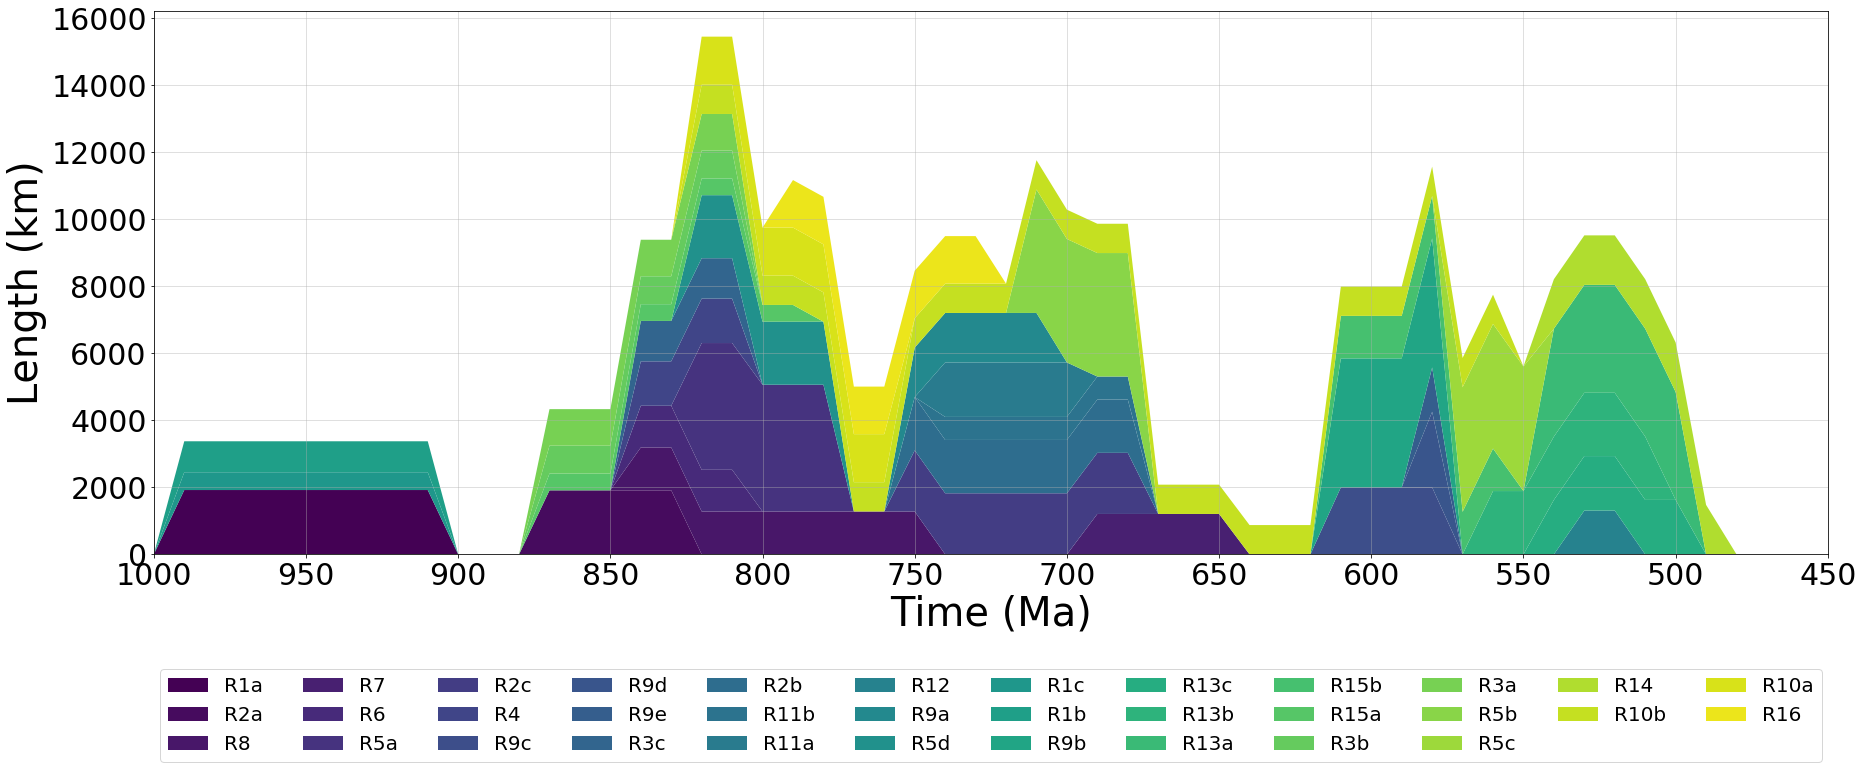

In [34]:
#stack plot of rift length from the Neoproterozoic
num_colours = len(rift_names)
cm = plt.get_cmap('viridis')
cNorm = colors.Normalize(vmin=0, vmax=num_colours)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,10), facecolor='w', edgecolor='k')
ax.set_color_cycle([scalarMap.to_rgba(i) for i in range(num_colours)])
ax.stackplot(plotting_times_Mer17GR,l_list)
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xlim(1000,450)
ax.set_xticks(np.arange(450,1050,50))
ax.xaxis.grid(True, alpha=.5)
ax.yaxis.grid(True, alpha=.5)
ax.set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
ax.set_ylabel('Length (km)', fontsize=axes_title_fontsize)
ax.legend(rift_names, loc='lower center', ncol=12,bbox_to_anchor=(0.5,-0.4),fontsize=leg_font)
#plt.savefig("Rift-length-1000-450-stacked.pdf", bbox_inches='tight')

In [35]:
#set colour scale
num_colours = 9
cm = plt.get_cmap('viridis')
cNorm = colors.Normalize(vmin=0, vmax=num_colours)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

In [36]:
plotting_times_Mer17EPSL

array([   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
        110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
        220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
        330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000])

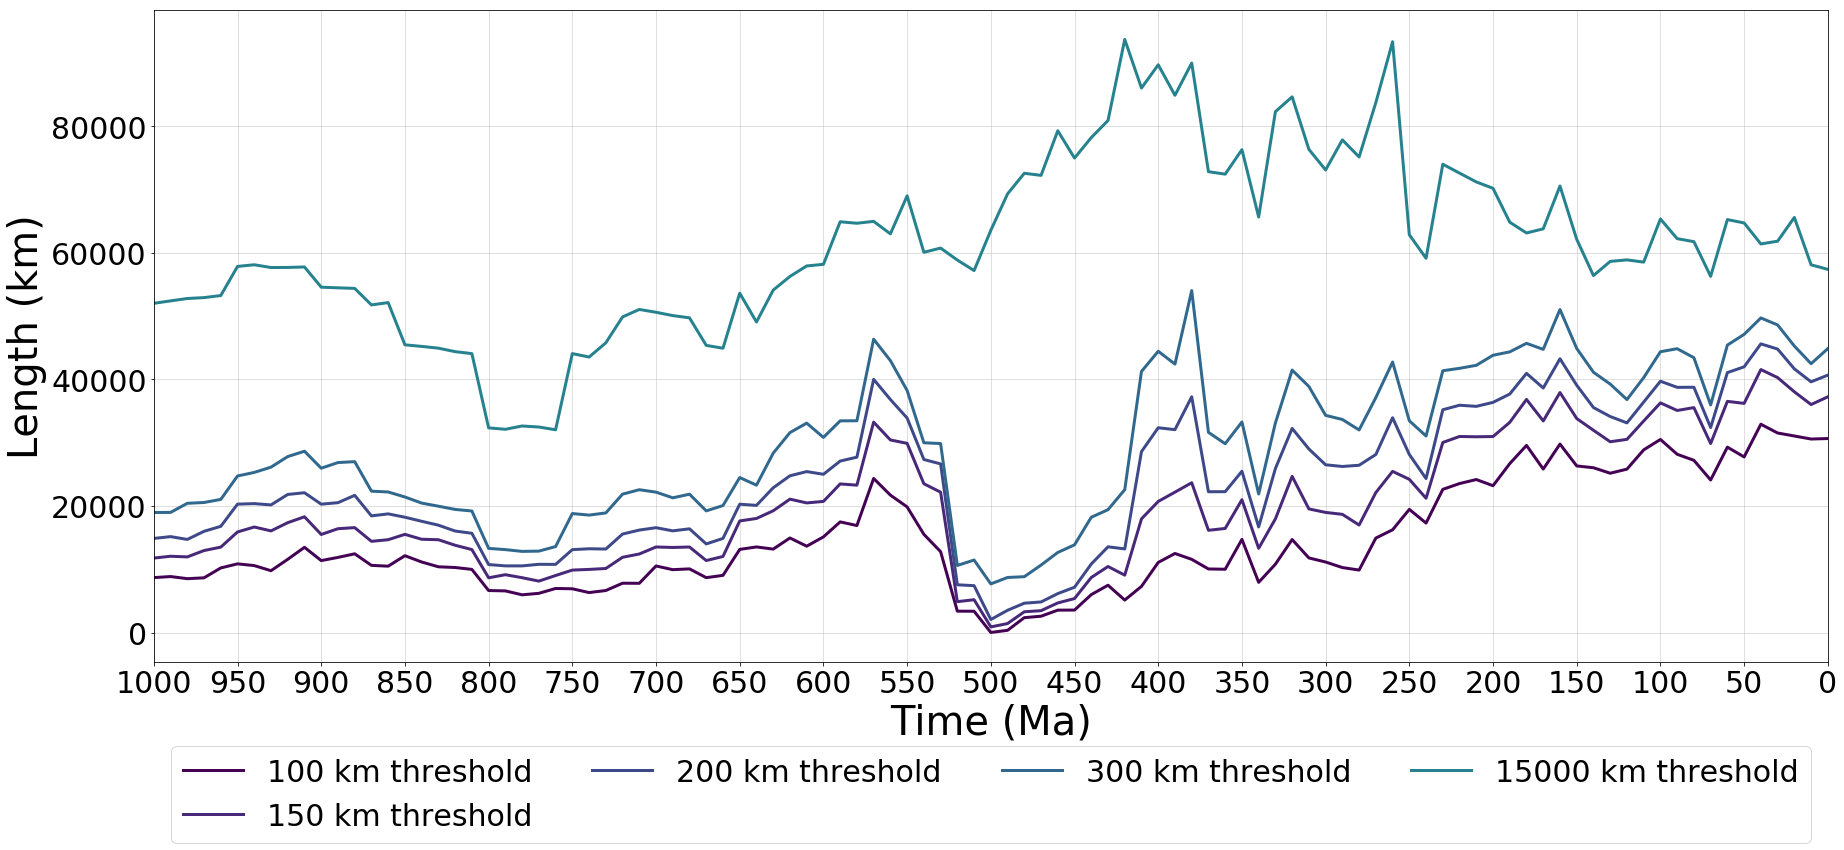

In [38]:
#just arc length
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,12),facecolor='w', edgecolor='k')
ax.set_color_cycle([scalarMap.to_rgba(i) for i in range(0,5,1)])
#for data_labels, data_dict in total_continental_arc_length.items():
#    ax.plot(plotting_times_Mer17EPSL,data_dict, label=data_labels)
ax.plot(plotting_times_Mer17EPSL, total_continental_arc_length[100], linewidth=3, label='100 km threshold')
ax.plot(plotting_times_Mer17EPSL, total_continental_arc_length[150], linewidth=3, label='150 km threshold')
ax.plot(plotting_times_Mer17EPSL, total_continental_arc_length[200], linewidth=3, label='200 km threshold')
ax.plot(plotting_times_Mer17EPSL, total_continental_arc_length[300], linewidth=3, label='300 km threshold')
ax.plot(plotting_times_Mer17EPSL, total_continental_arc_length[15000], linewidth=3, label='15000 km threshold')
#ax.plot(plotting_times_Mer17EPSL, total_continental_arc_length['ocean'], linewidth=3, label='ocean arcs')
#ax.fill_between(plotting_times_Mer17EPSL, total_continental_arc_length[100], total_continental_arc_length[1000], alpha=0.1)
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xlim(1000,0)
ax.set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
ax.set_ylabel('Length (km)', fontsize=axes_title_fontsize)
ax.set_xticks(np.arange(0,1050,50))
ax.xaxis.grid(True, alpha=.5)
ax.yaxis.grid(True, alpha=.5)
ax.legend(ncol=4,loc='lower center',bbox_to_anchor=(0.5,-0.3),fontsize=30)
plt.savefig("Arc-length-1000-0-thresholds.pdf", bbox_inches='tight')

In [ ]:
#plot just rift length
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,12),facecolor='w', edgecolor='k')
for data_labels, data_dict in total_rift_length.items():
    ax.plot(plotting_times_Mer17EPSL,data_dict, label=data_labels, linewidth=3)
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xlim(1000,0)
ax.set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
ax.set_ylabel('Length (km)', fontsize=axes_title_fontsize)
ax.set_xticks(np.arange(0,1050,50))
ax.xaxis.grid(True, alpha=.5)
ax.yaxis.grid(True, alpha=.5)
ax.legend(ncol=2,loc='lower center',bbox_to_anchor=(0.5,-0.4),fontsize=32)
plt.savefig("Rift_length_1000-0.pdf", bbox_inches='tight')

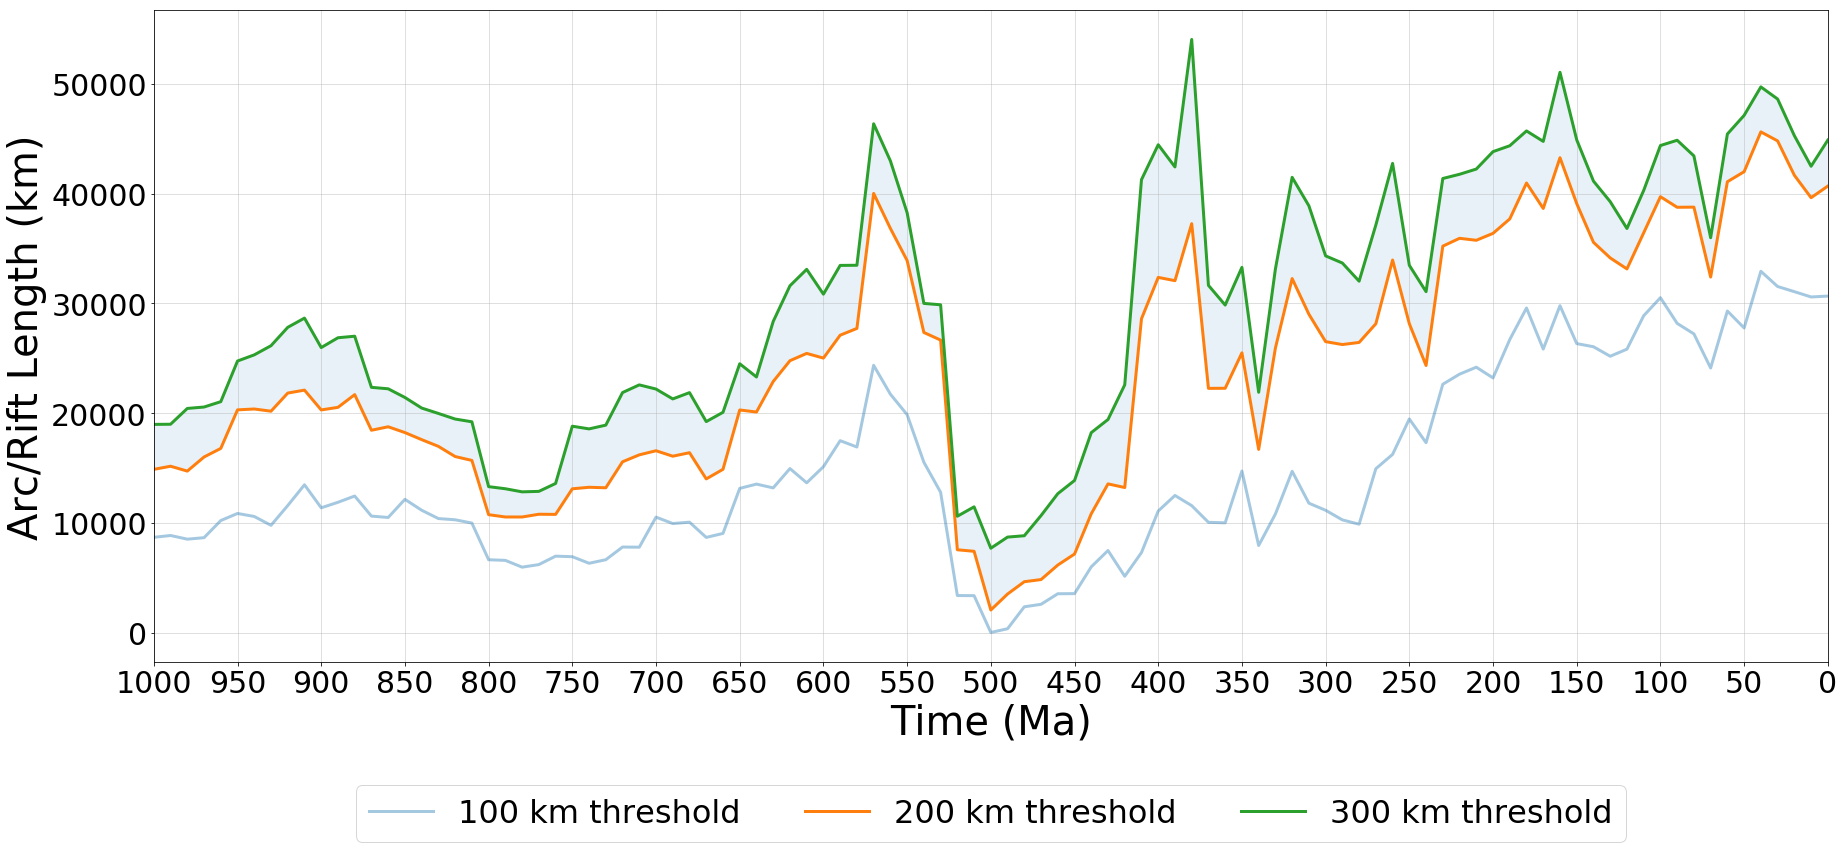

In [39]:
#plot arc length
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,12),facecolor='w', edgecolor='k')
ax.plot(plotting_times_Mer17EPSL, total_continental_arc_length[100], linewidth=3, alpha=0.4, label='100 km threshold')
ax.plot(plotting_times_Mer17EPSL, total_continental_arc_length[200], linewidth=3, label='200 km threshold')
ax.plot(plotting_times_Mer17EPSL, total_continental_arc_length[300], linewidth=3, label='300 km threshold')
ax.fill_between(plotting_times_Mer17EPSL, total_continental_arc_length[200], total_continental_arc_length[300], alpha=0.1)
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xlim(1000,0)
ax.set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
ax.set_ylabel('Arc/Rift Length (km)', fontsize=axes_title_fontsize)
ax.set_xticks(np.arange(0,1050,50))
ax.xaxis.grid(True, alpha=.5)
ax.yaxis.grid(True, alpha=.5)
ax.legend(ncol=4,loc='lower center',bbox_to_anchor=(0.5,-.3),fontsize=32)
plt.savefig("Arc_length_1000-0.pdf", bbox_inches='tight')

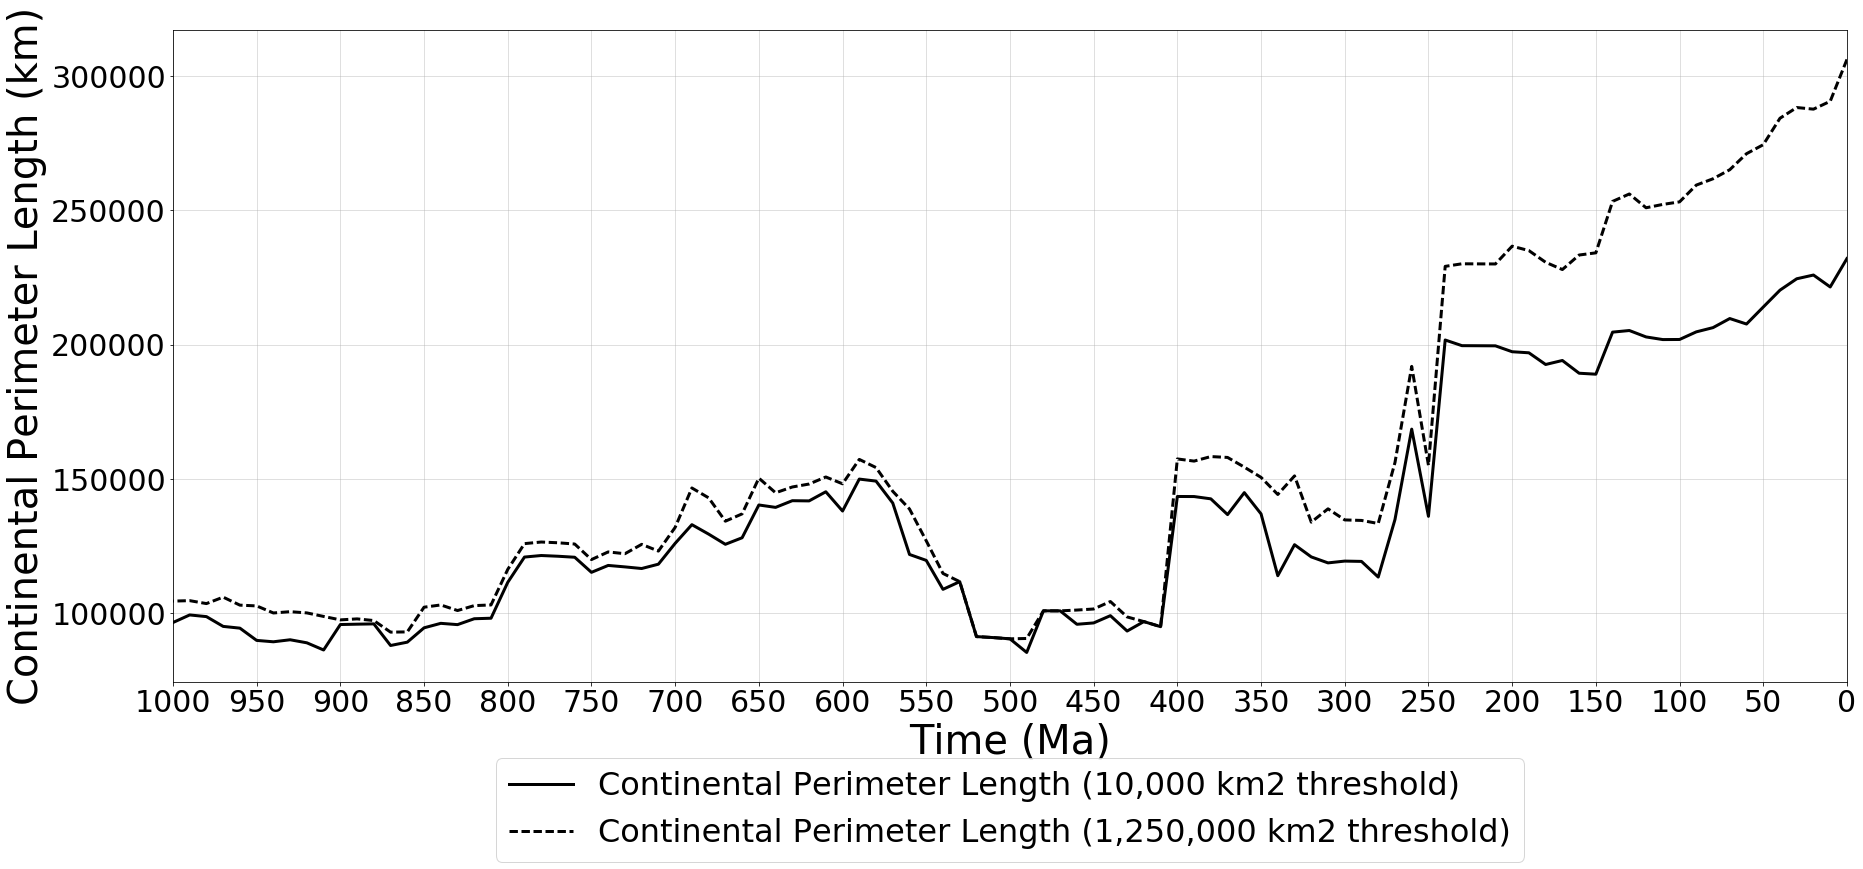

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,12),facecolor='w', edgecolor='k')
ax.plot(plotting_times_Mer17EPSL, plen_list, linewidth=linewidth, label='Continental Perimeter Length (10,000 km2 threshold)', color='k')
ax.plot(plotting_times_Mer17EPSL, plen_list2, linewidth=linewidth, label='Continental Perimeter Length (1,250,000 km2 threshold)', color='k', ls='--')
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.set_xlim(1000,0)
ax.set_ylabel('Continental Perimeter Length (km)', fontsize=axes_title_fontsize)
ax.set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
ax.set_xticks(np.arange(0,1050,50))
ax.xaxis.grid(True, alpha=.5)
ax.yaxis.grid(True, alpha=.5)
ax.legend(ncol=1,loc='lower center',bbox_to_anchor=(0.5,-0.3),fontsize=32)
plt.savefig("Continental-perimeter_length_1000-0.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,12),facecolor='w', edgecolor='k')
ax.plot(plotting_times_Mer17EPSL, plen_list, linewidth=linewidth, label='Continental Perimeter Length (5,000 km2 threshold)', color='k')
ax.plot(plotting_times_Mer17EPSL, plen_list2, linewidth=linewidth, label='Continental Perimeter Length (5,000,000 km2 threshold)', color='k', ls='--')
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.set_xlim(1000,0)
ax.set_ylabel('Continental Perimeter Length (km)', fontsize=axes_title_fontsize)
ax.set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
ax.set_xticks(np.arange(0,1050,50))
ax.xaxis.grid(True, alpha=.5)
ax.yaxis.grid(True, alpha=.5)
ax.legend(ncol=1,loc='lower center',bbox_to_anchor=(0.5,-0.3),fontsize=32)
plt.savefig("Continental-perimeter_length_1000-0.pdf", bbox_inches='tight')

In [ ]:
#plot everything (master version)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,12),facecolor='w', edgecolor='k')
ax2 = ax1.twinx()
ax1.plot(plotting_times_Mer17EPSL,total_continental_arc_length[100], linewidth=linewidth, alpha=0.2, label='Continental Arc Length (100 km threshold)')
ax1.plot(plotting_times_Mer17EPSL,total_continental_arc_length[200], linewidth=linewidth, alpha=0.2, label='Continental Arc Length (200 km threshold)')
ax1.plot(plotting_times_Mer17EPSL,total_continental_arc_length[300], linewidth=linewidth, label='Continental Arc Length (300 km threshold)')
for data_labels, data_dict in total_rift_length.items():
    ax1.plot(plotting_times_Mer17EPSL, data_dict, label=data_labels)
ax2.plot(plotting_times_Mer17EPSL, plen_list, linewidth=linewidth, label='COB', color='k', alpha=0.7)
ax2.plot(plotting_times_Mer17EPSL, plen_list2, linewidth=linewidth, label='COB2', color='k', ls='--', alpha=0.7)
ax1.fill_between(plotting_times_Mer17EPSL, total_continental_arc_length[200], total_continental_arc_length[300], alpha=0.1)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)
ax2.tick_params(axis='y', labelsize=tick_fontsize)
ax1.set_xlim(1000,0)
ax1.set_xticks(np.arange(0,1050,50))
ax1.set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
ax1.set_ylabel('Arc/Rift Length (km)', fontsize=axes_title_fontsize)
ax2.set_ylabel('COB Length (km)', fontsize=axes_title_fontsize)
ax1.xaxis.grid(True, alpha=.5)
ax1.yaxis.grid(True, alpha=.5)
ax2.yaxis.grid(True, alpha=.7, ls='-.')
ax1.legend(ncol=2,loc='lower center',bbox_to_anchor=(0.5,-0.5),fontsize=32)
ax2.legend(fontsize=32)
plt.savefig("Arc_Rift_length-1000-0.svg")

## old and unknown

In [ ]:
#extract
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,24),facecolor='w', edgecolor='k')

labels = []

for i,rift_with_conjugate in enumerate(rifts_with_conjugates):
    labels.append(rift_with_conjugate.get_name())
    rift_length = rift_with_conjugate.get_geometry().get_arc_length()
    individual_rift_length_kms = rift_length * pygplates.Earth.mean_radius_in_kms
    ax.plot([rift_with_conjugate.get_valid_time()[0],rift_with_conjugate.get_description()],[i,i],linewidth=individual_rift_length_kms/150)
    ax.plot([rift_with_conjugate.get_description(),rift_with_conjugate.get_valid_time()[1]],[i,i], c='k', linewidth=3)
        
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xlim(1000,520)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels((labels))

In [ ]:
#parameters
num_time_steps = 1000

In [ ]:
#extract total rift +passive margin length
rift_length = []
for rift in rifts:
    
    rift_length_over_time = []
    for time in range(520, num_time_steps, 1):
        #print time
        #print rift
        reconstructed_rift = []
        pygplates.reconstruct(rift, rotation_model, reconstructed_rift, time)
        #print reconstructed_rift
        if not reconstructed_rift:
            #print time
            rift_length_over_time.append(np.nan)
        else:
            for x in reconstructed_rift:
                #print x
                #print time
                #print reconstructed_rift
                if x is not None:
                    rift_at_time = x.get_feature().get_geometry().get_arc_length()
                    #print rift_at_time
                    individual_rift_at_time_kms = rift_at_time * pygplates.Earth.mean_radius_in_kms
                    #print individual_rift_at_time_kms
                    rift_length_over_time.append(individual_rift_at_time_kms)
                #if x is None:
                #    print time
                #    rift_length_over_time.append(0)
    rift_length.append(rift_length_over_time)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(80,32),facecolor='w', edgecolor='k')
x = times
for i in rift_length:
    ax.plot(x, i, linewidth=linewidth)
ax.tick_params(axis='x', labelsize=tick_fontsize, pad=60)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.set_xticks(major_ticks)
ax.set_xlim(1000,520)
ax.set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
ax.set_ylabel('Length (km)', fontsize=axes_title_fontsize)

In [ ]:
#extract total rift length through time for various files
#default rifts as best constrained by geology

total_rift_length = []
for time in range(410,num_of_time_steps+1,10):
    rift_length_total = 0.
    for rift in rifts:
        rift_length = rift.get_geometry().get_arc_length()
        individual_rift_length_kms = rift_length * pygplates.Earth.mean_radius_in_kms
        tmp_valid_time = np.arange(int(rift.get_valid_time()[1]), int(rift.get_description())+1, 1)
        #print rift.get_valid_time()[0] > time
        #print int(rift.get_description()) < time
        if (rift.get_valid_time()[0] > time) and (int(rift.get_description()) < time):
            rift_length_total+=individual_rift_length_kms

    total_rift_length.append(rift_length_total)
    
#extract total rift length through time for various files
#default rifts as best constrained by geology

valid_time = []

total_rift_length = []
for time in range(410,num_of_time_steps+1,10):
    rift_length_total = 0.
    for rift in rifts:
        rift_length = rift.get_geometry().get_arc_length()
        individual_rift_length_kms = rift_length * pygplates.Earth.mean_radius_in_kms
        tmp_valid_time = np.arange(int(rift.get_valid_time()[1]), int(rift.get_description())+1, 1)
        #print rift.get_valid_time()[0] > time
        #print int(rift.get_description()) < time
        if (rift.get_valid_time()[0] > time) and (int(rift.get_description()) < time):
            rift_length_total+=individual_rift_length_kms

    total_rift_length.append(rift_length_total)
    

#extract total rift length through time for various files
#rifts with failed rifts

valid_time = []

total_rift_length_with_failed_rifts = []
for time in range(410,num_of_time_steps+1,10):
    rift_length_total = 0.
    for rift in rifts_with_failed_rifts:
        rift_length = rift.get_geometry().get_arc_length()
        individual_rift_length_kms = rift_length * pygplates.Earth.mean_radius_in_kms
        tmp_valid_time = np.arange(int(rift.get_valid_time()[1]), int(rift.get_description())+1, 1)
        #print rift.get_valid_time()[0] > time
        #print int(rift.get_description()) < time
        if (rift.get_valid_time()[0] > time) and (int(rift.get_description()) < time):
            rift_length_total+=individual_rift_length_kms

    total_rift_length_with_failed_rifts.append(rift_length_total)
    
#extract total rift length for various files
#modelled additions (kalahari-laurentia, tarim-north china-aus)

valid_time = []

total_rift_length_modelled_additions = []
for time in range(410,num_of_time_steps+1,10):
    rift_length_total = 0.
    for rift in rifts_modelled_additions:
        rift_length = rift.get_geometry().get_arc_length()
        individual_rift_length_kms = rift_length * pygplates.Earth.mean_radius_in_kms
        tmp_valid_time = np.arange(int(rift.get_valid_time()[1]),
                                   int(rift.get_description())+1, 1)
        #print rift.get_valid_time()[0] > time
        #print int(rift.get_description()) < time
        if (rift.get_valid_time()[0] > time) and (int(rift.get_description()) < time):
            rift_length_total+=individual_rift_length_kms

    total_rift_length_modelled_additions.append(rift_length_total)
    
#extract total rift length for various files
#modelled additions and failed rifts

valid_time = []

total_rift_length_modelled_additions_failed_rifts = []
for time in range(410,num_of_time_steps+1,10):
    rift_length_total = 0.
    for rift in rifts_with_modelled_additions_failed_rifts:
        rift_length = rift.get_geometry().get_arc_length()
        individual_rift_length_kms = rift_length * pygplates.Earth.mean_radius_in_kms
        tmp_valid_time = np.arange(int(rift.get_valid_time()[1]),
                                   int(rift.get_description())+1, 1)
        #print rift.get_valid_time()[0] > time
        #print int(rift.get_description()) < time
        if (rift.get_valid_time()[0] > time) and (int(rift.get_description()) < time):
            rift_length_total+=individual_rift_length_kms

    total_rift_length_modelled_additions_failed_rifts.append(rift_length_total)

In [ ]:
import csv

my_dict = total_continental_arc_length_1000_410

with open('mycsvfile.csv', 'wb') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, my_dict.keys())
    w.writeheader()
    w.writerow(my_dict)